In [1]:
import matplotlib
matplotlib.use("Pdf")
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# set matplotlib parameters
params = {'backend': 'ps',
          'axes.labelsize': 13,
          'font.size': 13,
          'legend.fontsize': 13,
          'xtick.labelsize': 13,
          'ytick.labelsize': 13,
          'text.usetex': False,
          'text.latex.preamble': "\\usepackage{mathpazo}, \\usepackage{amsmath}"}
plt.rcParams.update(params)

import warnings 
warnings.filterwarnings("ignore") #ignore some matplotlib warnings

# numpy
import numpy as np

# Multiplet analysis & particle number histograms

Utilizing the cthyb functionality to measure the [many body density matrix](https://triqs.github.io/cthyb/unstable/guide/static_observables_notebook.html), it is possible to analyze the multiplet structure of the impurity states, e.g. occupation probabilities of eigenstates, find the associated particle number, and obtaining the spin state of those eigenstates. In principle all observables can be examined that are good quantum numbers of the system. More information of the measurement of the density matrix in cthyb can be found here: [cthyb measure static observables](https://triqs.github.io/cthyb/unstable/guide/static_observables_notebook.html).

This tutorial will demonstrate, based on the above mentioned [tutorial](https://triqs.github.io/cthyb/unstable/guide/static_observables_notebook.html), how to analyze the multiplet structure from a measured density matrix and the `h_loc_diag` object of the solver. For more information on how to measure those properties please take a look first [here](https://triqs.github.io/cthyb/unstable/guide/static_observables_notebook.html). This tutorial will not give the reader a full introduction to the physical background of the discussed matter, it is more designed for someone who is already familiar with the matter itself, seeking for a guide on how to perform such analysis with triqs.

Let us consider a single-orbital Anderson impurity problem. At first, we import all necessary modules, define some input parameters and construct a cthyb Solver object in the usual way:

In [2]:
from h5 import HDFArchive
from triqs.gf.descriptors import Fourier
from triqs.gf import Gf, MeshImFreq, iOmega_n, inverse, GfImTime, BlockGf, Wilson
from triqs.operators import c, c_dag, n

# redirect cthyb c++ output to notebook
from triqs.utility.redirect import start_redirect
start_redirect()

from triqs_cthyb.solver import Solver

Starting run with 1 MPI rank(s) at : 2020-09-18 07:57:58.642240


In [3]:
# Parameters
D = 1.0         # Half-bandwidth of the bath
V = 0.4         # Hybridisation amplitude
U = 4.0         # Coulomb interaction
e_f = -U/2      # Local energy level
beta = 1       # Inverse temperature

# Construct the impurity solver with the inverse temperature
# and the structure of the Green's functions
S = Solver(beta = beta, gf_struct = [ ('up',[0]), ('down',[0]) ])

# Initialize the non-interacting Green's function S.G0_iw
S.G0_iw['up']   << inverse(iOmega_n - e_f - V**2 * Wilson(D))
S.G0_iw['down'] << inverse(iOmega_n - e_f - V**2 * Wilson(D))

# setting up a local interaction Hamiltonian
h_int = U * n('up',0) * n('down',0)

Next, we instruct the ``solve`` function to accumulate the density matrix by passing the solver parameters ``measure_density_matrix = True`` and ``use_norm_as_weight = True``. See also [cthyb solver parameters](https://triqs.github.io/cthyb/latest/reference/solve_parameters.html) for more information.

Now we run the solver:

In [4]:
# Run the solver
S.solve(h_int = h_int,                  # interaction Hamiltonian
        n_cycles  = 500000,             # Number of QMC cycles
        length_cycle = 200,             # Length of one cycle
        n_warmup_cycles = 10000,        # Warmup cycles
        measure_density_matrix = True,  # Measure the reduced density matrix
        use_norm_as_weight = True)      # Required to measure the density matrix


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
-2*c_dag('down',0)*c('down',0) + -2*c_dag('up',0)*c('up',0) + 4*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
07:57:58  12% ETA 00:00:00 cycle 1279 of 10000



Accumulating ...
07:57:59   0% ETA 00:00:30 cycle 1620 of 500000
07:58:01   6% ETA 00:00:31 cycle 31153 of 500000
07:58:04  14% ETA 00:00:27 cycle 72956 of 500000
07:58:07  24% ETA 00:00:23 cycle 124185 of 500000
07:58:11  37% ETA 00:00:19 cycle 189226 of 500000
07:58:16  54% ETA 00:00:14 cycle 270958 of 500000
07:58:22  73% ETA 00:00:08 cycle 365660 of 500000
07:58:30  98% ETA 00:00:00 cycle 490624 of 500000


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure                                    | seconds   
Average si

## Analysis of results

Next we do the actual analysis of the multiplet structure. First we need to setup the operators, that we want to measure:

In [5]:
from triqs.operators.util import make_operator_real
from triqs.operators.util.observables import S_op, S2_op
from triqs.atom_diag import quantum_number_eigenvalues

Here, we are going to take a look at $S_z, \ S^2,$ and $N$. The two central objects we need for the analysis are:

In [6]:
# accumulated many body density matrix
rho = S.density_matrix
# the atom diag object containing information about the H_loc entering the solver
h_loc_diag = S.h_loc_diagonalization

`rho` is the many body density matrix, which stores the occupation probability for each eigenstate of the impurity Hamiltonian, and `h_loc_diag` contains information about the impurity Hamiltonian, e.g. eigenstates, eigenvalues, Fock states ... 

To evaluate the expectation values of $S_z, \ S^2,$ and $N$ values we first create the operators:

In [7]:
# first get fundamental operators of H_loc from atom_diag object
occ_operators = [n(*op) for op in h_loc_diag.fops]

# construct total occupation operator from list
N_op = sum(occ_operators)

# create S2 and Sz operator
spin_names = ['up', 'down']
orb_names = [0]

# The spin operators are created from orbital and spin names
# the flag off_diag determines if blocks of Gf are down_0 / up_0 ,
# or down / up 
S2 = S2_op(spin_names, orb_names, off_diag=True)
Sz=S_op('z', spin_names, orb_names, off_diag=True)

Next we evaluate the operators in the impurity eigenstates by using the [triqs.atom_diag](https://triqs.github.io/triqs/latest/documentation/manual/triqs/atom_diag/contents.html) function [quantum_number_eigenvalues](https://triqs.github.io/triqs/latest/documentation/cpp_api/triqs/atom_diag/quantum_number_eigenvalues.html). The object will be sorted by the subspaces contained in h_loc_diag:

In [8]:
# get eigenvalues of S2 and Sz
S2_states = quantum_number_eigenvalues(S2, h_loc_diag)
Sz_states = quantum_number_eigenvalues(Sz, h_loc_diag)

# get particle numbers from h_loc_diag
particle_numbers = quantum_number_eigenvalues(N_op, h_loc_diag)
N_max = int(max(map(max, particle_numbers)))

In [9]:
print(particle_numbers)

[array([1.]), array([1.]), array([0.]), array([2.])]


One can see, that `particle_numbers` contains now 4 numpy arrays, representing the 4 subspaces of the impurity problem. Those are actually identified by different particle numbers $0,1,$ and $2$. Each array has the size of number of eigenstates in that particular subspace.

Now we construct the eigenstates for each eigenvalue of `h_loc_diag` in their corresponding subspace, which can be also labeled by the quantum numbers that we just extracted. Finally, `rho` will contain the actual probability that this eigenstate is occupied:

In [10]:
multiplet_occ = np.zeros(N_max + 1)

# we loop through all subspaces, which are just indexed as integers
for sub in range(0,h_loc_diag.n_subspaces):   

    print("subspace No.:", sub)

    # first get Fock space spanning the subspace
    fs_states = []
    for ind, fs in enumerate(h_loc_diag.fock_states[sub]):
        # get state in binary representation
        state = bin(int(fs))[2:].rjust(N_max, '0')
        fs_states.append("|"+state+">")

    # now we loop over all eigenstates within the subspace
    for ind in range(h_loc_diag.get_subspace_dim(sub)):

        # get particle number
        # carefully here to not cast to int as the particle number
        # can be something like 1.999999996 and would get then 1! 
        particle_number = int(round(particle_numbers[sub][ind]))
        # here you can see that the object obtained from quantum_number_eigenvalues
        # is structured in the same way as h_loc_diag
        
        # get spin operator values in the same way
        ms=Sz_states[sub][ind]
        s_square=S2_states[sub][ind]
       
        # energy of state
        eng=h_loc_diag.energies[sub][ind]

        # probability that this state is occupied is obtained from rho
        prob = rho[sub][ind,ind]
        
        # add to multiplet histogram sorted by particle number
        multiplet_occ[particle_number] += prob
        
        # construct eigenvector in Fock state basis by rotation 
        ev_state = ''
        for i, elem in enumerate(h_loc_diag.unitary_matrices[sub][:,ind]):
            ev_state += ' {:+1.4f}'.format(elem)+fs_states[i]

        # print info obtained
        print("EV No:", ind,
              ", N=",particle_number,
              ", E="+"{:1.5f}".format(eng) ,
              ", prob:"+"{:1.5f}".format(prob),
              ", S(S+1): "+"{:1.2f}".format(s_square),
              ", ms: "+"{:1.2f}".format(ms),
              ",\n eigenstate:", ev_state)
        
    print('----')

print('multiplet occupation by particle number: \n', multiplet_occ)
print('sum of multiplet occ: '+"{:1.5f}".format(np.sum(multiplet_occ)))

subspace No.: 0
EV No: 0 , N= 1 , E=0.00000 , prob:0.43381 , S(S+1): 0.75 , ms: 0.50 ,
 eigenstate:  +1.0000|01>
----
subspace No.: 1
EV No: 0 , N= 1 , E=0.00000 , prob:0.43393 , S(S+1): 0.75 , ms: -0.50 ,
 eigenstate:  +1.0000|10>
----
subspace No.: 2
EV No: 0 , N= 0 , E=2.00000 , prob:0.06625 , S(S+1): 0.00 , ms: 0.00 ,
 eigenstate:  +1.0000|00>
----
subspace No.: 3
EV No: 0 , N= 2 , E=2.00000 , prob:0.06601 , S(S+1): 0.00 , ms: 0.00 ,
 eigenstate:  +1.0000|11>
----
multiplet occupation by particle number: 
 [0.06624796 0.86774326 0.06600878]
sum of multiplet occ: 1.00000


It can be observed that the main contribution is coming from eigenstates with $N=1$ with $m_s=\pm 0.5$ as expected, and that the Fock states are the eigenvectors of the impurity system. The order of the orbitals in the Fock states is given by the order of operators in `h_loc_diag.fops` starting from the right site, with the first half representing one spin-channel and the second half representing the other spin-channel. Note, that in general each eigenstate can be a linear combination of Fock states. This can be important in sub-spaces with dimension $>1$, when manually using the information stored in `rho`.

The occupations can now be ploted has histogram.

### plot particle number histogram

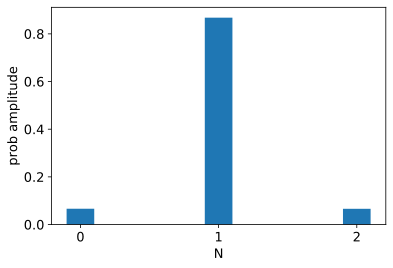

In [11]:
fig, (ax1) = plt.subplots(1,1,figsize=(6,4))

ax1.bar(range(0,len(multiplet_occ)) ,multiplet_occ, width=0.2)


ax1.set_xlabel(r'N')
ax1.set_ylabel(r'prob amplitude')

ax1.set_xticks(list(range(0,len(multiplet_occ))))        

plt.show()

It can be observed, that due to the high temperature of $\beta=1$ the two excited states are slightly populated, but the $N=1$ states have the highest occupation probability.

## More complex example

The previous example was quite simple. We also provide a function doing the analysis with a few extra checks, storing the result as [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html): 

In [12]:
import pandas as pd
pd.set_option('display.width', 130)

from triqs_cthyb.multiplet_tools import multiplet_analysis

In [13]:
print(multiplet_analysis.__doc__)


    Computes operator expectation values from measured
    density matrix and h_loc_diag object from cthyb solver.

    Measures N, Sz, S(S+1), constructs eigenstates in Fock state
    basis, assigns the according probabilities from rho for all
    impurity eigenstates, and stores the data in a Panda DataFrame.
    For more information check the guide in the documentation of cthyb
    regarding `Multiplet analysis & particle number histograms`.

    quantum numbers, labeling the eigenstates of the system.

    Parameters
    ----------
    rho : numpy array
        measured density matrix from cthyb or equivalent solver, structured in subspaces
    h_loc_diag: triqs atom_diag object
        contains information about the local Hamiltonian (Hloc_0 + H_int)
    orb_names : list of int
        list of orbital indices
    spin_names : list of string
        list of strings containing the spin channel names
    off_diag: boolean
        determines whether blocks of Gf are named up_0 (false

Now we can use this function to analyze a stored result from a realistic five orbital calculation with an occupation of ~8.5 electrons:

In [14]:
with HDFArchive('density_matrix_example.h5','r') as ar:
    rho_5orb = ar['rho']
    h_loc_diag_5orb = ar['h_loc_diag']

Calling the function does the whole analysis at once:

In [15]:
res_5orb = multiplet_analysis(rho = rho_5orb, 
                             h_loc_diag = h_loc_diag_5orb, 
                             # five orbitals
                             orb_names = [0, 1, 2, 3, 4],
                             # two spin channels
                             spin_names = ['up','down'],
                             # and no off-diag elements have been used in the solver
                             off_diag = False)

print the 15 eigenstates with highest occupation probability

In [16]:
print(res_5orb.sort_values('prob', ascending=False)[:15])

    Sub#  EV#   N    energy      prob    S2  m_s  |m_s|                                              state
3      1    1   9  0.144618  0.185854  0.75  0.5    0.5            +1.0000|1111111101> +0.0000|1111111110>
1      0    1   9  0.144618  0.185387  0.75 -0.5    0.5            +1.0000|1110111111> +0.0000|1111011111>
12     4    0   8  0.048852  0.063419  2.00  1.0    1.0                                +1.0000|1111111100>
4      2    0   8  0.048852  0.063355  2.00 -0.0    0.0   -0.0000|0111101111> -0.0000|1011110111> +0.00...
11     3    0   8  0.048852  0.063293  2.00 -1.0    1.0                                +1.0000|1110011111>
55    20    0  10  6.036870  0.043536  0.00  0.0    0.0                                +1.0000|1111111111>
0      0    0   9  0.000000  0.042266  0.75 -0.5    0.5            +0.0000|1110111111> +1.0000|1111011111>
2      1    0   9  0.000000  0.042165  0.75  0.5    0.5            +0.0000|1111111101> +1.0000|1111111110>
5      2    1   8  1.190955  0.034021

This shows a nice representation of the top occupied eigenstates and their quantum numbers.

A side note: as earlier mentioned, one can see that the eigenstates are linear combinations of Fock states here. This becomes important when for example analyzing the occupation of a single orbital in that given subspace. Let's assume we want to know what the probability is of the first orbital to be occupied in the $N=8$ particle sector. To obtain the result one needs to evaluate $Tr(\rho n_0)$ in the given subspace. $n_0$ is diagonal in the Fock basis, but it is not necessarily diagonal in the eigenbasis of the system. Therefore, one needs to first rotate $\rho$ into the Fock basis: $U \cdot \rho \cdot U^\dagger$, with $U$ beeing `h_loc_diag.unitary_matrices[sub]`, and then one can obtain the occupation probability of this orbital from the diagonal elements of $\rho$ in the Fock basis. 


The results obtained from the multiplet analysis can now be easily accessed for further post-processing. For example the occupation probabilities per particle number are obtained by running the command:

In [17]:
print(res_5orb.groupby(['N']).sum()['prob'])

N
0     0.000000e+00
1     0.000000e+00
2     0.000000e+00
3     0.000000e+00
4     9.937759e-08
5     2.319210e-05
6     1.790289e-03
7     5.183764e-02
8     4.129959e-01
9     4.898165e-01
10    4.353634e-02
Name: prob, dtype: float64


Plotting the data is also achieved in similar ways. Here, we plot the particle number histogram, as well as the particle number histogram resolved by spin state:

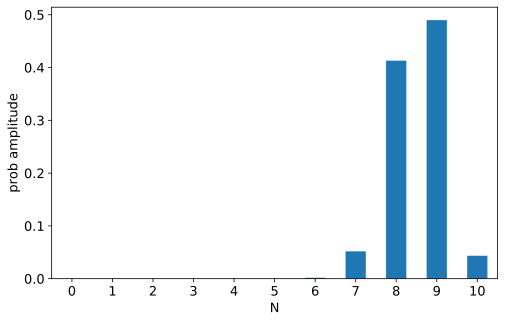

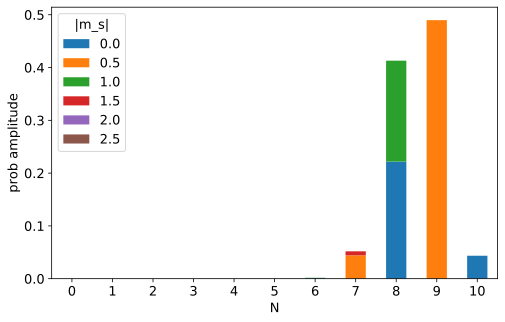

In [18]:
fig, (ax1) = plt.subplots(1,1,figsize=(8,5))

mult_occ_5orb = res_5orb.groupby(['N']).sum()['prob']
mult_occ_5orb.plot.bar(y='prob' ,ax=ax1, rot=0)

ax1.set_xlabel(r'N')
ax1.set_ylabel(r'prob amplitude')
plt.show()

# split into ms occupations
fig, (ax1) = plt.subplots(1,1,figsize=(8,5))

spin_occ_five = res_5orb.groupby(['N', '|m_s|']).sum()
pivot_df = spin_occ_five.pivot_table(index='N', columns='|m_s|', values='prob')
pivot_df.plot.bar(stacked = True, rot=0, ax = ax1)

ax1.set_ylabel(r'prob amplitude')        
plt.show()